In [ ]:
%%capture
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle

from helpers import read_echogram

In [ ]:
class EchoGram:
    def __init__(self, filename, channels=None, depthline=False):
        self.filename = filename
        self.data, self.echo = self.test_overlay_wb_echo(filename, channels, depthline)
        self.df = pd.DataFrame(self.data)
        self.lat_lon_to_meters(self.df["longitude"].to_numpy(), self.df["latitude"].to_numpy())
        
        del self.data
        
    def test_overlay_wb_echo(self, filename, channels=None):
        """ Load sounding data and echogram and plot the entire sonar image. 
            The library, Python SLLIB, used in the helpers.py file, decodes the SL2 file format from Lowrance sonar sounder and
            converts it to two simple data types, one is data, a list of dictionaries, which is later converted to a pandas dataframe,
            a table with the values of the different variables that the sonar outputs, and the second data type is a ndarray that
            represents the image that the sonar outputs. 
            
            Input: 
            Filename: string containing the sl2 file location
            Channel: sonar sensor type
                - 0 = Primary (Traditional Sonar)
                - 1 = Secondary (Traditional Sonar)
                - 2 = DSI (Downscan Imaging)
                - 3 = Sidescan Left
                - 4 = Sidescan Right
                - 5 = Sidescan (Composite)
                Another other value is treated as Invalid.
        """
        data, echo = read_echogram(filename, channels)

        fig, axes = plt.subplots()
        axes.imshow(echo, aspect='auto')
        if depthline:
            axes.plot([i["frame_index"] for i in data],
                        wb_s, linewidth=2, color="red")
        fig.show()
        #fig.savefig('sss.png', dpi=fig.dpi)
        return data, echo
    
    def lat_lon_to_meters(self, lon, lat, x0=-9147145.64754388, y0=3427601.097538607):
        """ Convert longitude and latitude to global X and Y coordinates in meters
            Inputs:
                lon: longitude 
                lat: latitude
                x0: X position of the origin in the new map
                y0: Y position of the origin in the new map
            NOTE: default of x0 and y0 is (an eyeballed) bottom left point in CITRA pond, Florida
        """
        # Using Spherical Pseudo-Mercator projection
        # https://wiki.openstreetmap.org/wiki/Mercator
        R =  6378137.0
        Y = np.log(np.tan(np.pi / 4 + np.radians(lat) / 2)) * R
        X = np.radians(lon) * R
        
        self.X = X - x0
        self.Y = Y - y0
        self.df["X_m"] = np.copy(self.X)
        self.df["Y_m"] = np.copy(self.Y)
        
    def see_range(self, range):
        fig, ax = plt.subplots()
        ax.plot(self.X, self.Y, 'ko', ms=0.5)
        ax.plot(self.X[range[0]:range[1]], self.Y[range[0]:range[1]], 'ro', ms=0.5)
        ax.set_aspect('equal')

    def crop_data(self, start, end):
        self.echo = np.delete(self.echo, slice(start,end), 1)
        self.df = self.df.drop(self.df.index[range(start,end)])
        self.X = np.delete(self.X, slice(start,end))
        self.Y = np.delete(self.Y, slice(start,end))

### October 2021 datasets:
- './log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2'    
- './log-data-lowrance/Sonar_2021-10-16_13.29.30.sl2'
- './log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.21.09.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2'

## File:Sonar_2021-10-16_12.53.38 Speed=4mph

  0%|          | 0.00/415M [00:00<?, ?B/s]

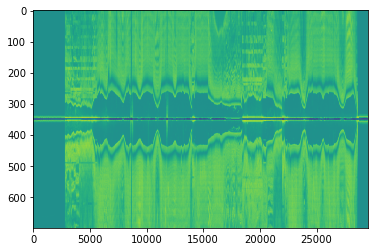

In [9]:
# Just run once to parse the sl2 file, then save the data of a variable in a file using pickle 
echo_4mph_101621 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2', channels=[5])

In [4]:
print(echo_4mph_101621.df.head())

dict_keys(['offset', 'previous_primary_offset', 'previous_secondary_offset', 'previous_downscan_offset', 'previous_left_sidescan_offset', 'previous_right_sidescan_offset', 'previous_composite_sidescan_offset', 'framesize', 'previous_framesize', 'channel', 'packetsize', 'frame_index', 'upper_limit', 'lower_limit', 'frequency', 'water_depth', 'keel_depth', 'gps_speed', 'temperature', 'lon_enc', 'lat_enc', 'water_speed', 'course', 'altitude', 'heading', 'flags', 'time1', 'has_altitude', 'has_heading', 'has_track', 'has_water_speed', 'has_position', 'has_packet', 'has_temperature', 'has_gps_speed', 'gps_speed_kph', 'longitude', 'latitude', 'water_depth_m', 'headersize', 'heading_deg'])
{'offset': 8, 'previous_primary_offset': 0, 'previous_secondary_offset': 0, 'previous_downscan_offset': 0, 'previous_left_sidescan_offset': 0, 'previous_right_sidescan_offset': 0, 'previous_composite_sidescan_offset': 8, 'framesize': 2944, 'previous_framesize': 0, 'channel': 5, 'packetsize': 2800, 'frame_ind

In [5]:
print("echo shape:",echo_4mph_101621.echo.shape)
print("type(data):",type(echo_4mph_101621.echo))

echo shape: (700, 29551)
type(data): <class 'list'>
length: 29551


In [12]:
rows, cols = echo_4mph_101621.echo.shape
vmin=min(echo_4mph_101621.echo.flat)
vmax=max(echo_4mph_101621.echo.flat)
print("min intensity=",vmin)
print("max intensity=",vmax)

min= -2143262300.0
max= 2141233300.0


## Visualize image segments with "hot" colors

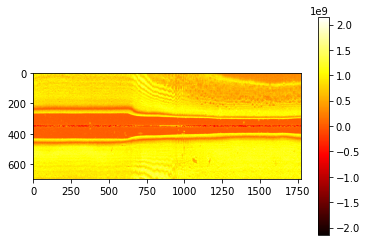

In [14]:
plt.imshow(echo_4mph_101621.echo[:,int(cols/2):int(cols*2.8/5)], cmap='hot', vmin=vmin, vmax=vmax)
plt.colorbar()

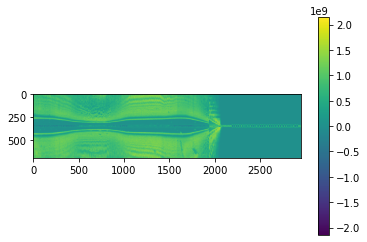

In [7]:
plt.imshow(echo_4mph_101621.echo[:,int(cols*9/10):-1],)
plt.colorbar()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

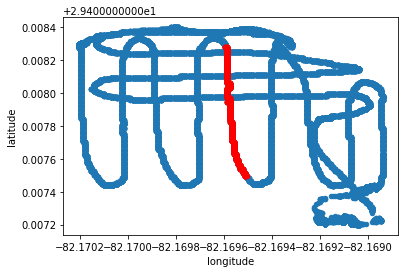

In [13]:
fig = plt.figure()
ax1 = echo_4mph_101621.df.plot.scatter(x="longitude", y="latitude")
echo_4mph_101621.df.loc[9600:10800,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax1)


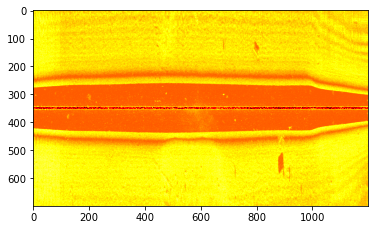

In [15]:
plt.imshow(echo_4mph_101621.echo[:,9600:10800], cmap='hot', vmin=vmin, vmax=vmax)

## File:Sonar_2021-10-16_13.29.36 Speed=6mph

  0%|          | 0.00/327M [00:00<?, ?B/s]

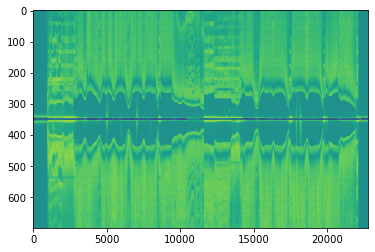

In [19]:
echogram6mph_101621 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2', channels=[5])

In [3]:
with open('processed_data/echogram6mph_101621.txt', 'rb') as file:
    # Call load method to deserialze
    echogram6mph_101621 = pickle.load(file)
    
with open('processed_data/echogram6mph_101621.txt', 'wb') as file:
    # A new file will be created
    pickle.dump(echogram6mph_101621, file)

length: 22784


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

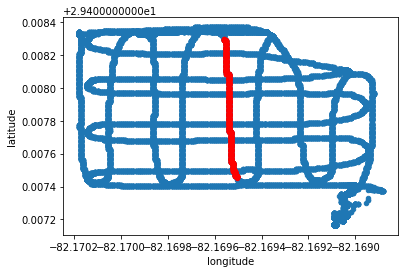

In [20]:
print("length:",len(echogram6mph_101621.data))
fig = plt.figure()
ax2 = echogram6mph_101621.df.plot.scatter(x="longitude", y="latitude")
echogram6mph_101621.df.loc[5600:6400,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax2)

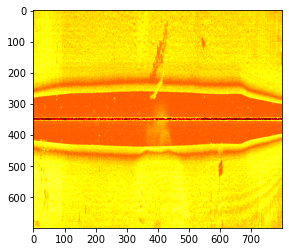

In [14]:
plt.imshow(echogram6mph_101621.echo[:,5600:6400], cmap='hot')

## File:Sonar_2021-10-16_14.38.24 Speed=7mph

  0%|          | 0.00/141M [00:00<?, ?B/s]

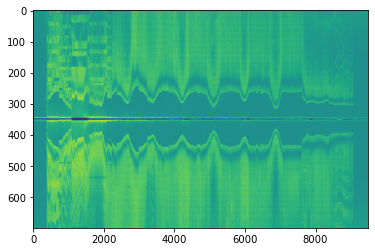

In [8]:
echogram7mph_101621 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2', channels=[5])

length: 9491


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

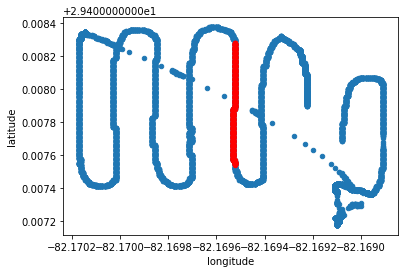

In [11]:
print("length:",len(echogram7mph_101621.data))
fig = plt.figure()
ax3 = echogram7mph_101621.df.plot.scatter(x="longitude", y="latitude")
echogram7mph_101621.df.loc[4400:5000,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax3)

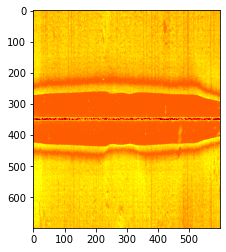

In [20]:
vmin=min(echogram7mph_101621.echo.flat)
vmax=max(echogram7mph_101621.echo.flat)
plt.imshow(echogram7mph_101621.echo[:,4400:5000], cmap='hot', vmin=vmin, vmax=vmax)

# DownScan Sonar

  0%|          | 0.00/415M [00:00<?, ?B/s]

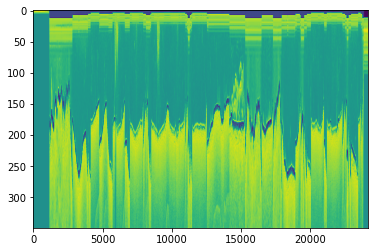

In [5]:
downscan = EchoGram('./log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2', channels=[2], depthline=False)

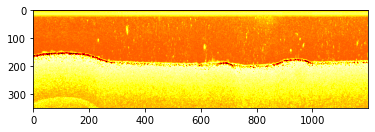

In [6]:
plt.imshow(downscan.echo[:,9600:10800], cmap='hot')

## North-South and East-West comparisson

In [3]:
import os
ls = os.listdir('log-data-lowrance/02_20_22')
print(ls)

['Sonar_2022-01-20_16.16.03.sl2', 'Sonar_2022-01-20_10.45.23.sl2', 'Sonar_2022-01-20_09.53.33.sl2', 'Sonar_2022-01-20_15.54.19.sl2', 'Sonar_2022-01-20_11.05.09.sl2']


  0%|          | 0.00/417M [00:00<?, ?B/s]

  0%|          | 0.00/277M [00:00<?, ?B/s]

  0%|          | 0.00/194M [00:00<?, ?B/s]

  0%|          | 0.00/369M [00:00<?, ?B/s]

  0%|          | 0.00/431M [00:00<?, ?B/s]

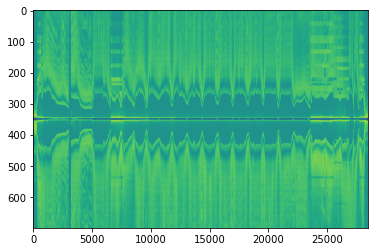

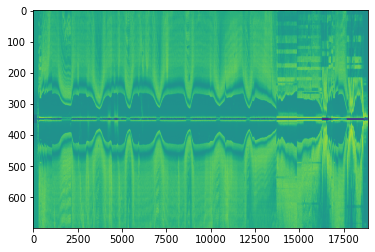

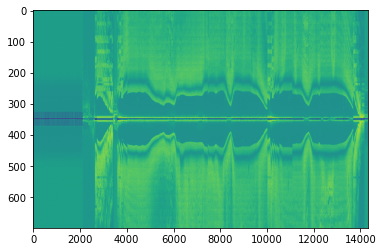

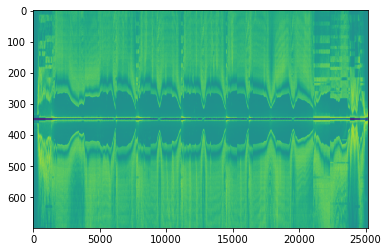

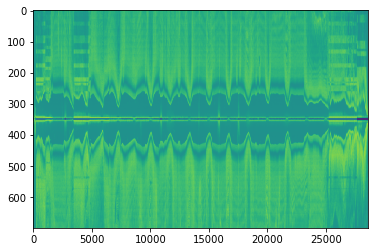

In [7]:
dataset_012022 = {}
for file in ls:
    dataset_012022[file] = EchoGram('./log-data-lowrance/02_20_22/'+file, channels=[5])

In [4]:
# Include the October run to the dataset
#dataset_012022["Sonar_2021-10-16_13.29.36.sl2"] = echogram6mph_101621

files = ls+["Sonar_2021-10-16_13.29.36.sl2"]
print(files)

['Sonar_2022-01-20_16.16.03.sl2', 'Sonar_2022-01-20_10.45.23.sl2', 'Sonar_2022-01-20_09.53.33.sl2', 'Sonar_2022-01-20_15.54.19.sl2', 'Sonar_2022-01-20_11.05.09.sl2', 'Sonar_2021-10-16_13.29.36.sl2']


In [180]:
# Run this to save the variables to a file
with open('processed_data/noso.txt', 'wb') as file: 
    # A new file will be created
    pickle.dump(NO_SO, file)
with open('processed_data/eawe.txt', 'wb') as file: 
    pickle.dump(EA_WE, file)
with open('processed_data/dataset_012022.txt', 'wb') as file:  
    pickle.dump(dataset_012022, file)

In [5]:
# Run this to retrieve the variables from a file
with open('processed_data/noso.txt', 'rb') as file:
    # Call load method to deserialze
    NO_SO = pickle.load(file)
with open('processed_data/eawe.txt', 'rb') as file:
    EA_WE = pickle.load(file)
with open('processed_data/dataset_012022.txt', 'rb') as file:
    dataset_012022 = pickle.load(file)

xmin:  3.01009226962924


<Figure size 432x288 with 0 Axes>

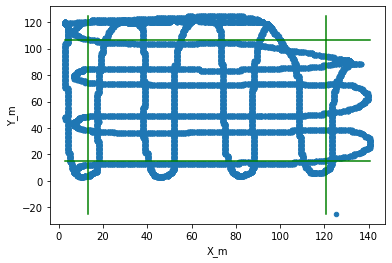

In [44]:
# approximate limits of axis for plotting
xmin = dataset_012022[files[5]].df["X_m"].min()
xmax = dataset_012022[files[5]].df["X_m"].max()
ymin = dataset_012022[files[5]].df["Y_m"].min()
ymax = dataset_012022[files[5]].df["Y_m"].max()

fig = plt.figure()
ax2 = dataset_012022[files[5]].df.plot.scatter(x="X_m", y="Y_m")
ax2.plot([xmin+10]*2,[ymin,ymax], 'g')
ax2.plot([xmax-20]*2,[ymin,ymax], 'g')
ax2.plot([xmin,xmax],[ymin+40]*2, 'g')
ax2.plot([xmin,xmax],[ymax-18]*2, 'g')

In [186]:
# Initialize the arrays for the comparisson
NO_SO = np.array([[600, 1800, 5]])
EA_WE = np.array([[11500, 12600, 5]])

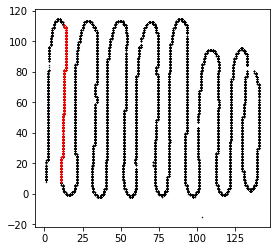

In [179]:
start= 15601
end = 16700
index_f = 0

dataset_012022[files[index_f]].see_range([start,end])

# Uncomment to include line 
#NO_SO = np.append(NO_SO, [[start, end, index_f]], axis=0)
#print("noso: \n", NO_SO)

# Uncomment to include line 
#EA_WE = np.append(EA_WE, [[start, end, index_f]], axis=0)
#print("eawe: \n",EA_WE)

#TO LOOK OUT FOR: there might not be great results for the datapoints (starting in 0):
#    no_so - 6,7,8,9,19,20,21,22
#    ea_we - 6,7,16,17

In [ ]:
#echogram6mph_101621.see_range([ea_we[0],ea_we[-1]])

# Ranges close to intersection points of file 5
#ea_we = range(1780,17350)
# ealine1 = range(14300,14750)
# ealine2 = range(15450,16200)
# ealine3 = range(16480,17350)
# nsline2 = range(4650,5380)
# nsline3 = range(5640,6350)
# nsline4 = range(6700,7400)
#no_so0 = range(5060,5110)
#ea_we0 = range(17900,17950)
#no_so_dict = {"0":no_so0, "1":no_so1, "2":no_so2, "3":nsline3, "4":nsline3, "5":nsline3, "6":nsline4, "7":nsline4, "8":nsline4, "9":nsline2, "10":nsline2, "11":nsline2}
#ea_we_dict = {"0":ea_we0, "1":ea_we1, "2":ea_we2, "3":ealine1, "4":ealine2, "5":ealine3, "6":ealine1, "7":ealine2, "8":ealine3, "9":ealine1, "10":ealine2, "11":ealine3}

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

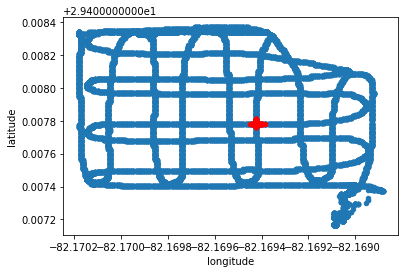

In [7]:
fig = plt.figure()
ax2 = df2.plot.scatter(x="x_m", y="y_m")
df2.loc[np.r_[no_so0,ea_we0],:].plot.scatter(x="x_m", y="y_m", c='red', ax=ax2)#  

In [221]:
def dir_comparison(no_so_model, no_so, ea_we_model, ea_we, is_plot=True):
    avg_lon_no_so = np.mean(no_so_model.df['X_m'].to_numpy()[no_so])
    avg_lat_ea_we = np.mean(ea_we_model.df['Y_m'].to_numpy()[ea_we])
    # Find index of minimumn distance between the two lines
    ea_we_in = np.argmin(np.abs(ea_we_model.df['X_m'].to_numpy()[ea_we]-avg_lon_no_so))
    no_so_in = np.argmin(np.abs(no_so_model.df['Y_m'].to_numpy()[no_so]-avg_lat_ea_we))
    diff_in = ea_we_in - no_so_in

    # Load depth values in cm
    no_so_depth = no_so_model.df['water_depth_m'].to_numpy()[no_so]*100
    ea_we_depth = ea_we_model.df['water_depth_m'].to_numpy()[ea_we]*100
    
    # Fit and generate a polynomial regressor
    no_so_poly = np.poly1d(np.polyfit(range(len(no_so_depth)), no_so_depth, 15))
    ea_we_poly = np.poly1d(np.polyfit(range(len(ea_we_depth)), ea_we_depth, 15))    
    
    E = no_so_poly(no_so_in) - ea_we_poly(ea_we_in) # Difference of depth between lines
    
    #TODO: return intersection 1 if there is actually an intersection, determined by the distance between closest point
    
    if is_plot: 
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(range(len(no_so_depth))+diff_in, no_so_depth, c='blue', s=4, alpha=0.8, label='North-South')
        ax.scatter(range(len(ea_we_depth)), ea_we_depth, c='red', s=4, alpha=0.8, label='East-West')
        ax.plot(range(len(no_so_depth))+diff_in, no_so_poly(range(len(no_so_depth))), c='mediumblue',)
        ax.plot(range(len(ea_we_depth)), ea_we_poly(range(len(ea_we_depth))), c='firebrick',)
        min_depth = np.min([np.min(no_so_depth), np.min(ea_we_depth)]) # get indices at edges of data range
        max_depth = np.max([np.max(no_so_depth), np.max(ea_we_depth)])
        ax.plot([no_so_in]*2+diff_in,[min_depth,max_depth], 'k', label='Intersection')
        #ax.plot([ea_we_in]*2,[min_depth,max_depth], 'r', label='East-West Intersection')
        ax.set_ylabel('Depth [cm]')
        ax.set_xlabel('Data points')
        ax.legend()#loc="lower right"
        plt.show()
        print("Error: ", E, "[cm]")
        fig.savefig('paper_figures/comparisson1.jpg', dpi=fig.dpi)

    return E

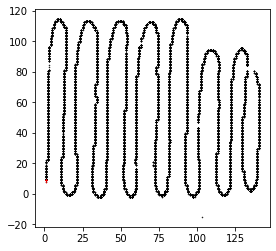

In [168]:
dataset_012022[files[no_so1[2]]].see_range([-10,-1])

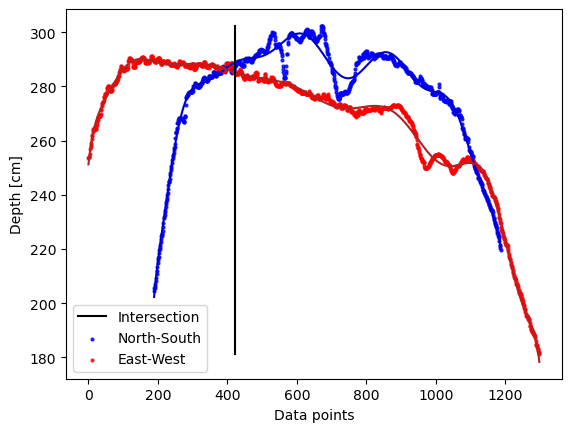

Error:  3.729422177971685 [cm]


3.729422177971685

In [222]:
no_so1 = [10401, 11400,     0]
ea_we1 = [12401, 13700,    3]
no_so_range1 = range(no_so1[0], no_so1[1])
ea_we_range1 = range(ea_we1[0], ea_we1[1])
dir_comparison(dataset_012022[files[no_so1[2]]], no_so_range1, dataset_012022[files[ea_we1[2]]], ea_we_range1, is_plot=True)


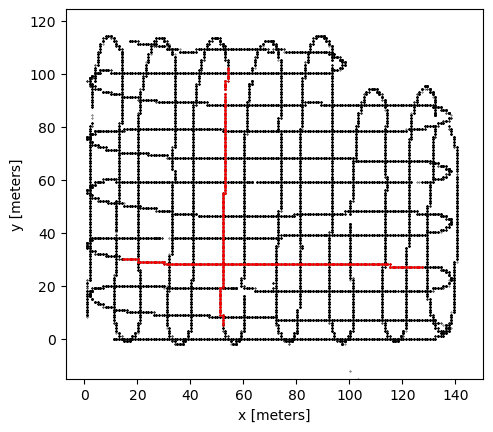

In [216]:
plt.style.use("default")

fig, ax = plt.subplots()
ax.scatter(dataset_012022[files[no_so1[2]]].X, dataset_012022[files[no_so1[2]]].Y, c='k', s=0.1, )
ax.scatter(dataset_012022[files[ea_we1[2]]].X, dataset_012022[files[ea_we1[2]]].Y, c='k', s=0.1)
ax.scatter(dataset_012022[files[no_so1[2]]].X[no_so_range1], dataset_012022[files[no_so1[2]]].Y[no_so_range1], c='r', s=0.1, )
ax.scatter(dataset_012022[files[ea_we1[2]]].X[ea_we_range1], dataset_012022[files[ea_we1[2]]].Y[ea_we_range1], c='r', s=0.1)
ax.set_aspect('equal')
ax.set_xlabel('x [meters]')
ax.set_ylabel('y [meters]')
plt.xlim(xmin-10, xmax+10)
plt.ylim(ymin+10, ymax)
plt.show()
fig.savefig('paper_figures/pattern1.jpg', dpi=fig.dpi)

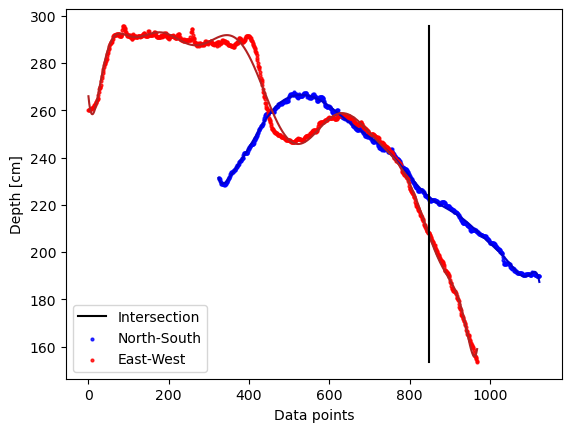

Error:  16.455063096860158 [cm]


16.455063096860158

In [220]:
no_so2 = [ 3200,  4000,     0]
ea_we2 = [ 6001,  6970,     3]
no_so_range2 = range(no_so2[0], no_so2[1])
ea_we_range2 = range(ea_we2[0], ea_we2[1])
dir_comparison(dataset_012022[files[no_so2[2]]], no_so_range2, dataset_012022[files[ea_we2[2]]], ea_we_range2, is_plot=True)


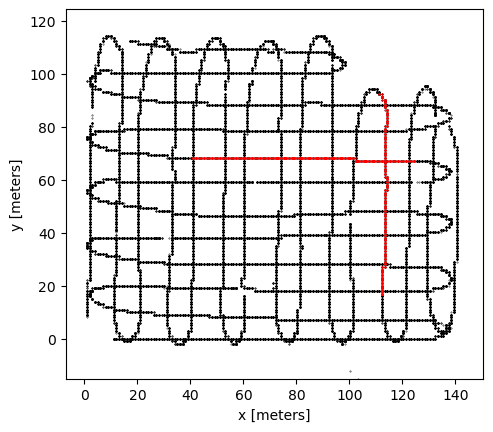

In [214]:
fig, ax = plt.subplots()
ax.scatter(dataset_012022[files[no_so2[2]]].X, dataset_012022[files[no_so2[2]]].Y, c='k', s=0.1, )
ax.scatter(dataset_012022[files[ea_we2[2]]].X, dataset_012022[files[ea_we2[2]]].Y, c='k', s=0.1)
ax.scatter(dataset_012022[files[no_so2[2]]].X[no_so_range2], dataset_012022[files[no_so2[2]]].Y[no_so_range2], c='r', s=0.1, )
ax.scatter(dataset_012022[files[ea_we2[2]]].X[ea_we_range2], dataset_012022[files[ea_we2[2]]].Y[ea_we_range2], c='r', s=0.1)
ax.set_aspect('equal')
ax.set_xlabel('x [meters]')
ax.set_ylabel('y [meters]')
plt.xlim(xmin-10, xmax+10)
plt.ylim(ymin+10, ymax)
plt.show()
fig.savefig('paper_figures/pattern2.jpg', dpi=fig.dpi)

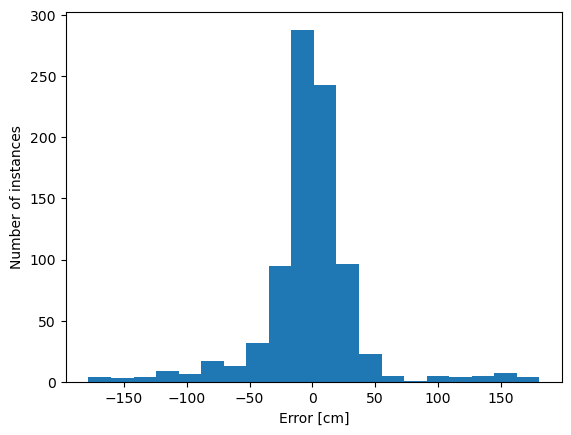

In [202]:
#import time

E_array = []
ii = 0
is_plot = False

for no_so in NO_SO:
    for ea_we in EA_WE:
        no_so_range = range(no_so[0], no_so[1])
        ea_we_range = range(ea_we[0], ea_we[1])
        E_array.append(dir_comparison(dataset_012022[files[no_so[2]]], no_so_range,
                                      dataset_012022[files[ea_we[2]]], ea_we_range, is_plot=False))
        if is_plot:
            print(ii)
            print("noso: ",no_so)
            print("eawe: ",ea_we)
            fig, ax = plt.subplots()
            ax.plot(dataset_012022[files[no_so[2]]].X[no_so_range], dataset_012022[files[no_so[2]]].Y[no_so_range], 'k', ms=0.5, )
            ax.plot(dataset_012022[files[ea_we[2]]].X[ea_we_range], dataset_012022[files[ea_we[2]]].Y[ea_we_range], 'ro', ms=0.5)
            ax.set_aspect('equal')
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.show()
            #time.sleep(2)
            ii +=1


E_array = np.array(E_array)
#E_array = E_array[E_array > -110]
plt.hist(E_array, bins=20)  # density=False would make counts
plt.ylabel('Number of instances')
plt.xlabel('Error [cm]');


Total # of points:  864
Mean:  -1.326238505485779
Standard Deviation:  39.49065254254678


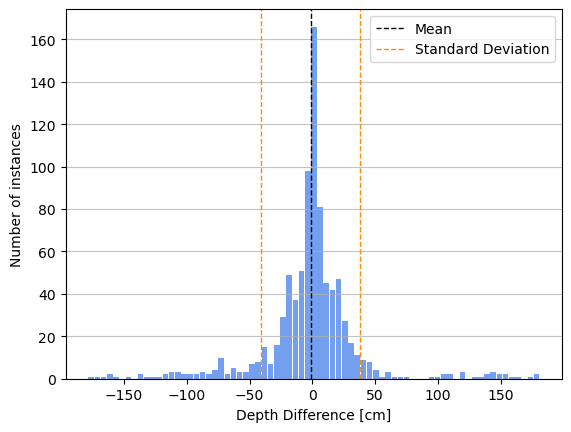

In [204]:
print("Total # of points: ",len(E_array))
print("Mean: ",E_array.mean())
print("Standard Deviation: ",E_array.std())

fig, axes = plt.subplots()
n, bins, patches = plt.hist(x=E_array, bins='auto', color='cornflowerblue',
                            alpha=0.9, rwidth=0.9)
plt.axvline(E_array.mean(), color='k', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(E_array.mean()+E_array.std(), color='darkorange', linestyle='dashed', linewidth=1, label="Standard Deviation")
plt.axvline(E_array.mean()-E_array.std(), color='darkorange', linestyle='dashed', linewidth=1, )
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Number of instances')
plt.xlabel('Depth Difference [cm]')
#plt.title('North-South and East West depth comparisson')
plt.legend()
plt.savefig('paper_figures/error_hist.jpg', dpi=fig.dpi)

## Jacksonville Data

  0%|          | 0.00/372M [00:00<?, ?B/s]

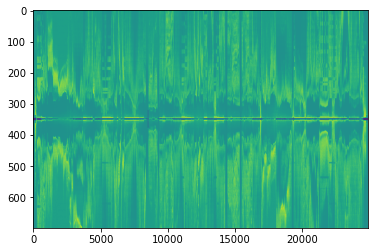

In [8]:
echogram_jax = EchoGram('./log-data-lowrance/Sonar_2022-01-06_14.10.26.sl2', channels=[5])
df_jax = pd.DataFrame(echogram_jax.data)

In [9]:
df2.to_csv("Sonar_2021-10-16_13.29.36.csv", columns=["longitude", "latitude", "water_depth_m"])
df_jax.to_csv("Sonar_2022-01-06_14.10.26.csv", columns=["longitude", "latitude", "water_depth_m"])